In [218]:
# Product segmentation techniques used from github user samirsaci. Please find below his github repo.
# https://github.com/samirsaci/product-segmentation


%matplotlib inline
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations 
from sklearn.cluster import KMeans
import folium
import ast

# Load data
df = pd.read_csv('full_sales.csv')
#df['order_date'] = pd.to_datetime(df['order_date'])
df['order_date'] = df['order_date'].astype('datetime64[ns]')
df['day'] = df['order_date'].dt.dayofyear
df['month'] = df['order_date'].dt.month
df['year'] = df['order_date'].dt.year
pd.options.display.max_rows = 20

for index, row in df.iterrows():
    years = {2019:1096, 2020:1461, 2017:366, 2018:731, 2016:0}
    
    df.at[index, 'day'] = row['day'] + years[row['year']]
pd.options.display.max_columns = None

In [209]:
abc = df.groupby([ 'product_name','day']).agg({'order_number': 'count'}).reset_index()
days = df['day'].unique()
days.sort()
days
products = df['product_name'].unique()
matrix = pd.DataFrame(products, columns=['product'])

for day in days:
    matrix[day] = 0
    for index, row in matrix.iterrows():
        search = abc[(abc['product_name']==row['product']) & (abc['day'] == day)]
        if not search.empty :
            matrix.at[index, day] += search['order_number']

prices = df[['product_name','unit_price']].drop_duplicates(subset=['product_name'], keep='first').reset_index()
prices['product'] = prices['product_name']
matrix = pd.merge(matrix, prices, on=['product'])


In [210]:

#mean
matrix['mean'] = matrix[days].mean(axis = 1)

# Standard
matrix['std'] = matrix[days].std(axis = 1)

# Total Units
matrix['units'] = matrix[days].sum(axis = 1)

# Turnover = Units x Price
matrix['TO'] = 0 
#prices = df[['product_name','unit_price']].drop_duplicates(subset=['product_name'], keep='first').reset_index()
#prices['product'] = prices['product_name']
#matrix = pd.merge(matrix, prices, on=['product'])

for col in days:    
    matrix['TO'] = matrix['TO'] + matrix[col] * matrix['unit_price']

# Coefficient of Variation
matrix['CV'] = matrix['std']/matrix['mean']


In [211]:
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
matrix

,product,1,2,3,4,5,6,7,8,9,...,1826,1827,index,product_name,unit_price,mean,std,units,TO,CV
0,Macadamia Style 5 Raw 11.34kg Bag,0,0,0,0,0,0,1,0,0,...,3,1,0,Macadamia Style 5 Raw 11.34kg Bag,26.26,0.727422,1.084658,1329,34899.54,1.491098
1,Japanese Rice Crackers 8kg Bag,0,0,0,0,0,0,0,0,0,...,2,3,2,Japanese Rice Crackers 8kg Bag,30.50,0.675972,1.082110,1235,37667.50,1.600821
2,Milk Chocolate Chips 10mm 15kg Bag,0,0,0,0,1,0,0,0,0,...,3,1,3,Milk Chocolate Chips 10mm 15kg Bag,31.55,0.690203,1.154698,1261,39784.55,1.672984
3,Almond Fine Meal 11.34kg Bag,0,0,0,0,0,0,0,0,0,...,4,3,5,Almond Fine Meal 11.34kg Bag,31.49,0.692939,1.074635,1266,39866.34,1.550836
4,Macadamia Style 6 Raw 11.34kg Bag,0,0,0,0,0,0,0,0,1,...,3,3,6,Macadamia Style 6 Raw 11.34kg Bag,26.60,0.717022,1.118083,1310,34846.00,1.559342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Banana Chips Broken (TBDC) 8.16kg Bag,0,0,0,0,0,0,0,0,0,...,4,1,221,Banana Chips Broken (TBDC) 8.16kg Bag,35.85,0.681445,1.083734,1245,44633.25,1.590348
91,Gluten Bumped Groats|Rolled Oats 25kg Bag,0,0,0,1,0,0,0,0,0,...,3,3,224,Gluten Bumped Groats|Rolled Oats 25kg Bag,27.02,0.690203,1.080205,1261,34072.22,1.565055
92,Banana Chips Whole 6.8kg Bag,0,0,0,0,0,0,0,0,0,...,8,2,285,Banana Chips Whole 6.8kg Bag,28.91,0.701697,1.128741,1282,37062.62,1.608587
93,Coconut Oil 190kg Drum FRUCOC005,0,0,0,0,0,0,2,0,0,...,3,3,394,Coconut Oil 190kg Drum FRUCOC005,24.92,0.677614,1.048421,1238,30850.96,1.547225


In [212]:
from scipy import stats
from scipy.stats import shapiro
# ABC SKU-LEVEL
df_abc = matrix.drop(['mean', 'std', 'CV', 'product_name' , 'index'], axis = 1).copy()
df_abc = df_abc.groupby(['product']).sum()

# Calculate mean and standard deviation
# Mean
df_abc['mean'] = df_abc[days].mean(axis = 1)
# Standard
df_abc['std'] = df_abc[days].std(axis = 1)
# Coefficient of Variation
df_abc['CV'] = df_abc['std']/df_abc['mean']
df_abc.reset_index(inplace = True)
# Normalility Test
df_abc['Normality_p'] = df_abc[days].apply(lambda row : stats.shapiro(row)[1], axis = 1)
alpha = 0.001
df_abc['Not_Normal'] = df_abc['Normality_p'] < alpha

# # ABC SKU-LEVEL
df_abc = df_abc.drop(days, axis =1).copy()
df_abc['TO%'] = (100*df_abc['TO']/df_abc['TO'].sum())
# Sort 
df_abc.sort_values(['TO%'], ascending = False, inplace = True, ignore_index=True)
df_abc['TO%_CS'] = df_abc['TO%'].cumsum()

# A, B, C on SKU Number
n_sku = len(df_abc)
n_a, n_b = int(0.05*n_sku), int(0.5*n_sku)
df_abc['SKU_ID'] = pd.Series(range(1, len(df_abc))).astype(int)
df_abc['SKU_%'] = (100 * pd.Series(range(1, len(df_abc))) / len(df_abc))
df_abc['ABC'] = pd.Series(range(len(df_abc))).apply(lambda t: 'A' if t <= n_a-1 else 'B' if t <= n_b-1 else 'C')
# A, B, C on turnover
to_a, to_b = df_abc[df_abc['SKU_ID']==n_a]['TO%'].max(), df_abc[df_abc['SKU_ID']==n_b]['TO%'].max()

print("{:,} unique SKU".format(len(df_abc)))
df_abc.head()

95 unique SKU


,product,unit_price,units,TO,mean,std,CV,Normality_p,Not_Normal,TO%,TO%_CS,SKU_ID,SKU_%,ABC
0,Sugar - Icing 25kg Bag,47.49,1290,61262.10,0.706076,1.087407,1.540072,0.0,True,1.653124,1.653124,1.0,1.052632,A
1,Mango Strips 12.5kg Bag,45.74,1331,60879.94,0.728517,1.131386,1.553000,0.0,True,1.642812,3.295936,2.0,2.105263,A
2,Honey 28kg Bucket SPIHON,47.27,1252,59182.04,0.685276,1.092149,1.593735,0.0,True,1.596995,4.892930,3.0,3.157895,A
3,Strawberry Dried 12.5kg Bag,46.20,1267,58535.40,0.693487,1.119466,1.614258,0.0,True,1.579545,6.472476,4.0,4.210526,A
4,Dates Whole Pitted 10kg Bag,44.64,1230,54907.20,0.673235,1.072386,1.592885,0.0,True,1.481640,7.954116,5.0,5.263158,B


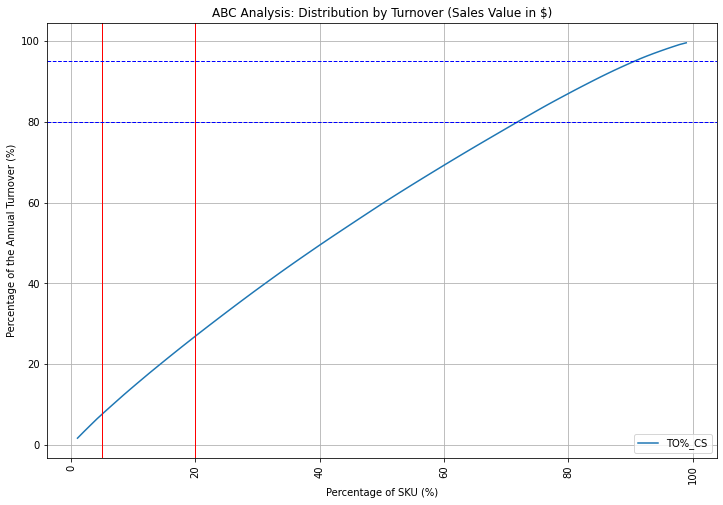

In [213]:
# Distribution by Value
ax = plt.gca()
df_abc.plot(figsize=(12, 8), x='SKU_%', y='TO%_CS', ax =ax, grid = True)
# ABC
# 20%, 50% of SKU Number
ax.axvline(5 , color="red", linestyle="-", linewidth = 1.0)
ax.axvline(20 , color="red", linestyle="-", linewidth = 1.0)
# 20%, 50% of SKU Number
ax.axhline(80 , color="blue", linestyle="--", linewidth = 1.0)
ax.axhline(95 , color="blue", linestyle="--", linewidth = 1.0)
plt.xlabel('Percentage of SKU (%)')
plt.xticks(rotation=90)
plt.ylabel('Percentage of the Annual Turnover (%)')
plt.title('ABC Analysis: Distribution by Turnover (Sales Value in $)')
plt.show()

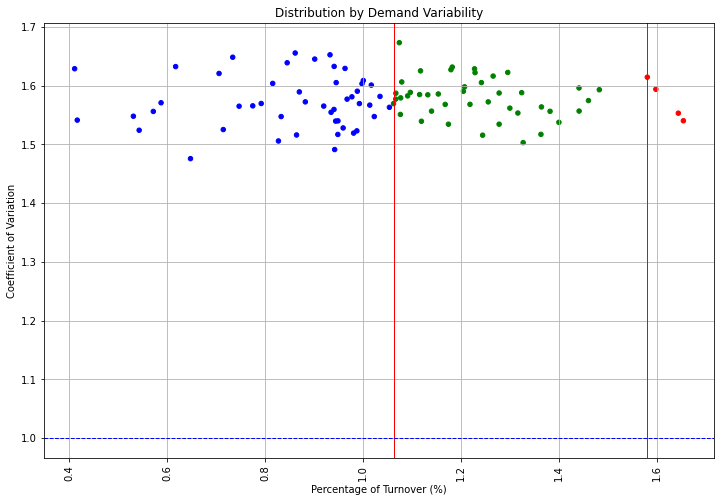

In [214]:
# Bar Chart
ax = plt.gca()
colors = {'A':'red', 'B':'green', 'C':'blue'}
# Remove Outliers
df_plot = df_abc[df_abc['CV']<4].copy()
df_plot.plot.scatter(figsize=(12, 8), x='TO%', y='CV', color=df_plot['ABC'].map(colors), ax =ax, grid = True)
# ABC
# A, B and C
ax.axvline(to_a , color="red", linestyle="-", linewidth = 1.0)
ax.axvline(to_b , color="red", linestyle="-", linewidth = 1.0)
# 20%, 50% of SKU Number
ax.axhline(1 , color="blue", linestyle="--", linewidth = 1.0)
plt.xlabel('Percentage of Turnover (%)')
plt.xticks(rotation=90)
plt.ylabel('Coefficient of Variation')
plt.title('Distribution by Demand Variability')
plt.show()

In [216]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df_abc

,product,unit_price,units,TO,mean,std,CV,Normality_p,Not_Normal,TO%,TO%_CS,SKU_ID,SKU_%,ABC
0,Sugar - Icing 25kg Bag,47.49,1290,61262.10,0.706076,1.087407,1.540072,0.0,True,1.653124,1.653124,1.0,1.052632,A
1,Mango Strips 12.5kg Bag,45.74,1331,60879.94,0.728517,1.131386,1.553000,0.0,True,1.642812,3.295936,2.0,2.105263,A
2,Honey 28kg Bucket SPIHON,47.27,1252,59182.04,0.685276,1.092149,1.593735,0.0,True,1.596995,4.892930,3.0,3.157895,A
3,Strawberry Dried 12.5kg Bag,46.20,1267,58535.40,0.693487,1.119466,1.614258,0.0,True,1.579545,6.472476,4.0,4.210526,A
4,Dates Whole Pitted 10kg Bag,44.64,1230,54907.20,0.673235,1.072386,1.592885,0.0,True,1.481640,7.954116,5.0,5.263158,B
5,High Oleic Sunflower Oil *Procured on firm Ord...,42.96,1259,54086.64,0.689108,1.084950,1.574427,0.0,True,1.459498,9.413614,6.0,6.315789,B
6,Raisins Medium Choice 12.5kg Bag,43.79,1219,53380.01,0.667214,1.038594,1.556613,0.0,True,1.440430,10.854044,7.0,7.368421,B
7,Papaya Cubes 20kg Bag,42.63,1252,53372.76,0.685276,1.093652,1.595929,0.0,True,1.440234,12.294279,8.0,8.421053,B
8,Apricot Turkish 12.5kg Bag,40.99,1265,51852.35,0.692392,1.064493,1.537414,0.0,True,1.399207,13.693486,9.0,9.473684,B
9,Peanuts Blanched - (40/50) Raw 25kg Bag,40.08,1277,51182.16,0.698960,1.087726,1.556206,0.0,True,1.381122,15.074608,10.0,10.526316,B


In [219]:
df_abc.to_csv("segmentation.csv", sep=',')